In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import keras

from somefunc import *
%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.style.use('default')

images_path = "data/images"

In [138]:
df = pd.read_csv('data/cleaned_by_etienne.csv')

df["product_category_tree"] = df["product_category_tree"].apply(clean_categ)
df['path_file'] = df["uniq_id"].apply(get_path_file)
df['categ_0'] = df["product_category_tree"].apply(get_subcateg, deepness = 0)

df.drop(columns=['crawl_timestamp','product_url','pid', 'retail_price', 'discounted_price',
'image','is_FK_Advantage_product','product_rating','overall_rating','brand','product_specifications','uniq_id'],inplace=True)

categ_0_list_num, categ_0_names= pd.factorize(df['categ_0'])


images_list = get_img_list(df.path_file.values)

(224, 224, 3)


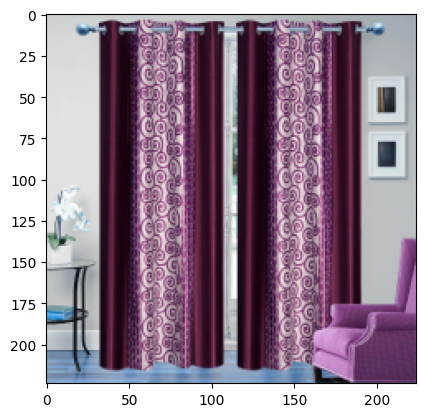

In [25]:
import matplotlib
matplotlib.style.use('default')

img = images_list[0]
print(img.shape)
plt.imshow(img)

Réaliser dans un premier temps une analyse d’une image et différentes approches de transformation : 
# niveaux de gris, equalization, filtrage bruit, contraste, floutage… 
(affichage image et histogramme associés).

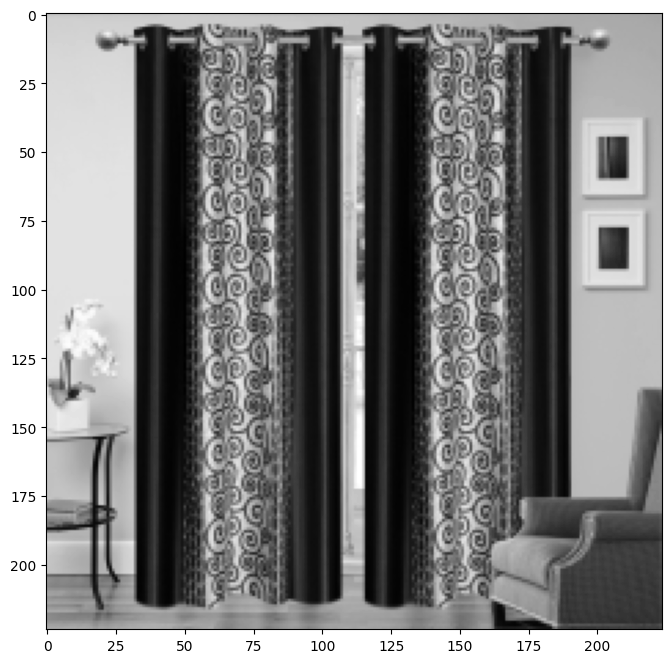

In [26]:
from skimage.color import rgb2gray
from skimage import exposure
img = rgb2gray(img)
plt.figure(figsize=(8,8))
plt.imshow(img,cmap='gray')

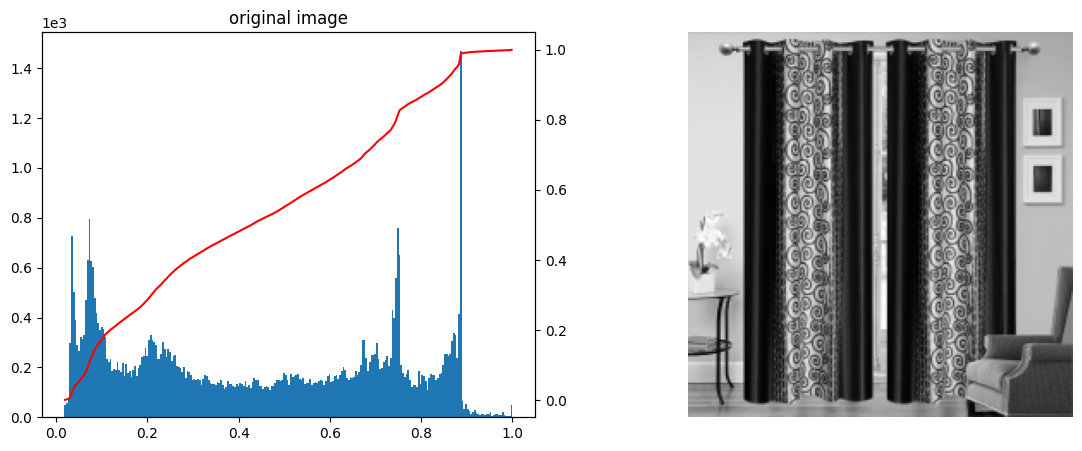

In [27]:
bins = 256
fig,ax= plt.subplots(figsize=(14,5))
ax1  = plt.subplot2grid((1,2), (0, 0))
ax1.set_title('original image')
ax1.hist(img.ravel(),bins=bins)
ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

ax1_bis = ax1.twinx()
img_cdf, bins = exposure.cumulative_distribution(img, bins)
ax1_bis.plot(bins, img_cdf, 'r')

ax2  = plt.subplot2grid((1,2), (0, 1))
ax2.axis('off')
plt.imshow(img,cmap='gray')

plt.show()

In [28]:
def plot_img_hist(image,title='toto'):
    bins = 256
    fig, ax = plt.subplots(figsize=(14,5))
    ax1  = plt.subplot2grid((1,2), (0, 0))
    ax1.set_title(title)
    ax1.hist(image.ravel(),bins=bins)
    ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

    ax1_bis = ax1.twinx()
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax1_bis.plot(bins, img_cdf, 'r')

    ax2  = plt.subplot2grid((1,2), (0, 1))
    plt.imshow(image,cmap='gray')

    plt.show()

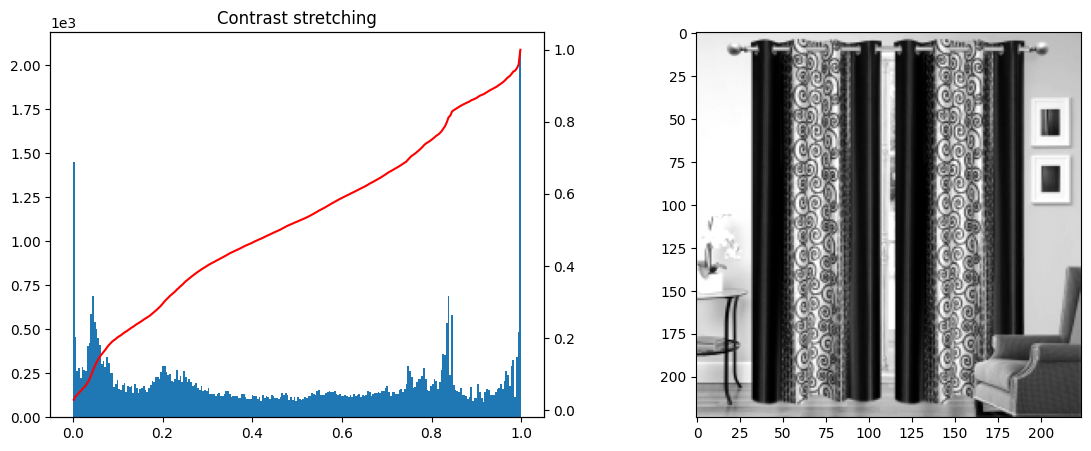

In [29]:
import numpy as np
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
plot_img_hist(img_rescale,'Contrast stretching')

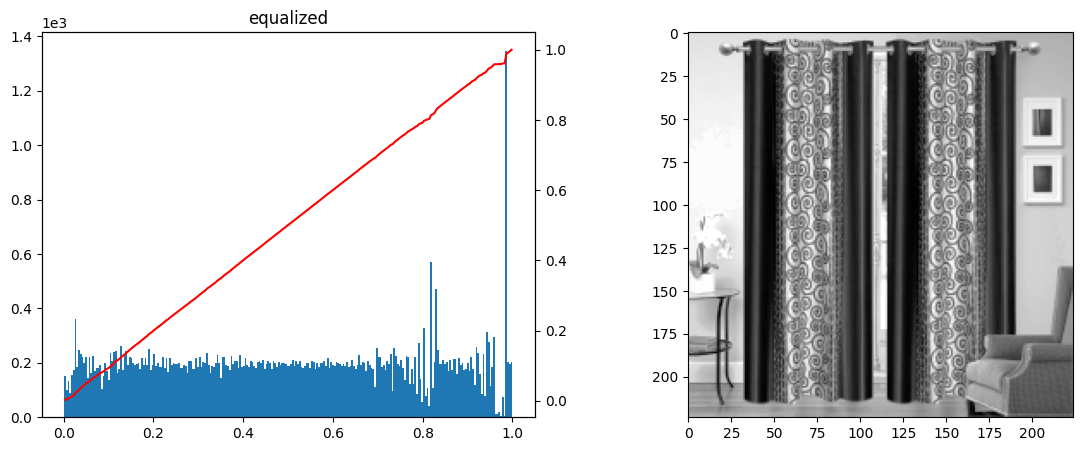

In [30]:
# Equalization
img_eq = exposure.equalize_hist(img)
plot_img_hist(img_eq,'equalized')

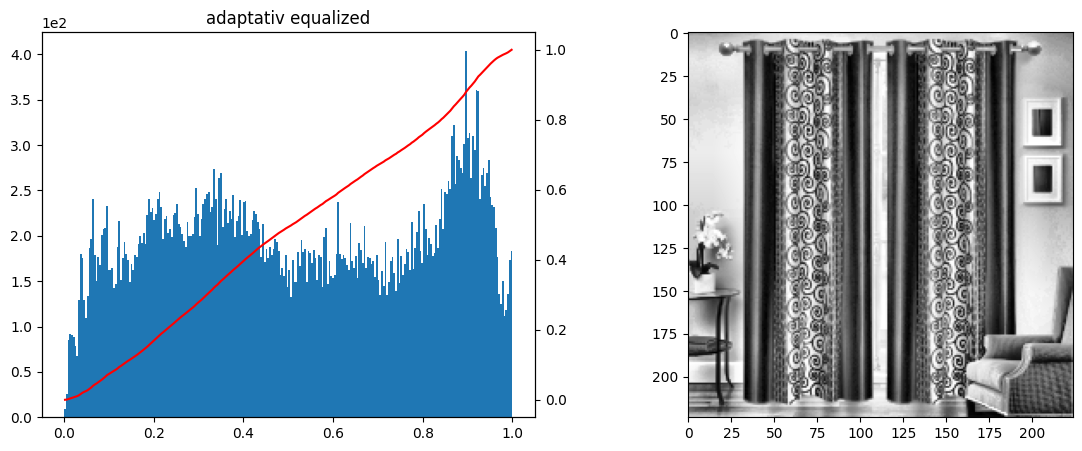

In [31]:
#Adaptatif Histogram Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
plot_img_hist(img_adapteq,'adaptativ equalized')

C:\Users\fuetu\AppData\Local\Temp\ipykernel_7652\4168574985.py:6: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  img_local_eq = rank.equalize(img, footprint=footprint)


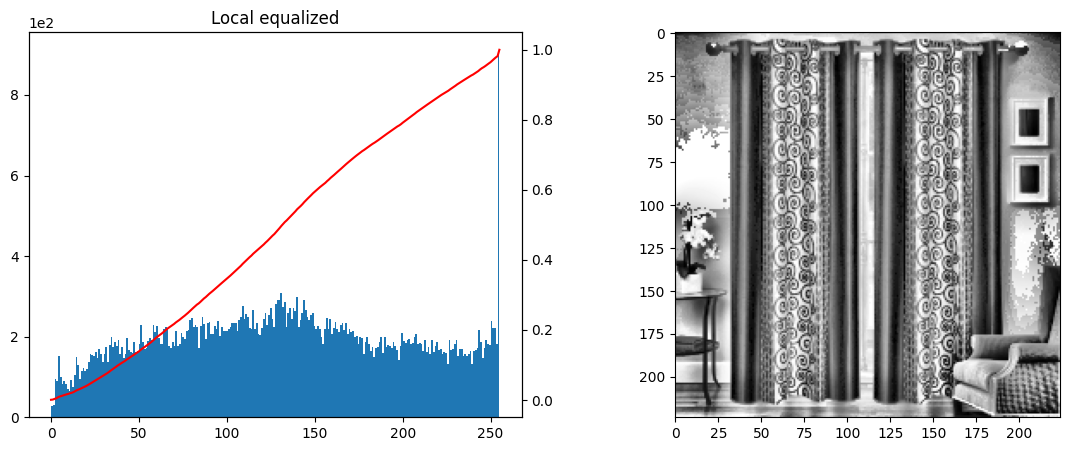

In [32]:
#Local Histogram Equalization

from skimage.morphology import disk
from skimage.filters import rank
footprint = disk(20)
img_local_eq = rank.equalize(img, footprint=footprint)
plot_img_hist(img_local_eq,'Local equalized')

In [33]:
df["product_category_tree"].value_counts(ascending=False)

Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars                         56
Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs                           26
Watches >> Wrist Watches >> Maxima Wrist Watches                                  23
Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs                         22
Home Furnishing >> Bath Linen >> Towels                                           19
                                                                                  ..
Home Decor & Festive Needs >> Showpieces >> Ethnic >> Infinity India Ethnic        1
Home Decor & Festive Needs >> Showpieces >> Ethnic >> Ravishing Variety Ethnic     1
Home Decor & Festive Needs >> Showpieces >> Ethnic >> Pg handicrafts Ethnic        1
Home Decor & Festive Needs >> Showpieces >> Ethnic >> Homedesires Ethnic           1
Watches >> Wrist Watches >> Petrol Wrist Watches                                   1
Name: product_category_tree, Length: 642, dtype: int64

In [34]:
df[df["product_category_tree"] == "Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]

product_name  \
103    Rama Floral Single Quilts & Comforters Pink-Red   
104      Rama Floral Single Quilts & Comforters Yellow   
105    Shop Rajasthan Abstract Single Dohar Multicolor   
107  Artisan Creation Checkered Single Quilts & Com...   
108  Rama Floral Single Quilts & Comforters Blue-Beige   
701                   Sapatos Plain Single Duvet White   
703                  Sapatos Plain Single Dohar Fushia   
704  Home Originals Abstract, Abstract Double Blank...   
705  RajasthaniKart Floral Double Quilts & Comforte...   
707  Home Originals Polka, Abstract Double Blanket ...   
708                 Indigocart Plain Double Dohar Grey   
711  Frabjous Floral Single Quilts & Comforters Mul...   
713  Home Originals Abstract, Geometric Double Blan...   
714  Home Originals Abstract, Checkered Double Blan...   
715         Pioneer Pragati Floral Single Duvet Orange   
716  Home Originals Geometric, Striped Double Blank...   
717                    Sapatos Plain Single Duvet Blue   
718  Home Originals Abstract Double Quilts & Comfor...   
720       Sapatos Geometric Single Duvet Purple & Pink   
721              SPANGLE Floral King Blanket CC0070001   
722                     Sapatos Plain Single Duvet Red   
749  Rajasthan Crafts Abstract Single Quilts & Comf...   
750  Rajasthan Crafts Abstract Single Quilts & Comf...   
751  Rajasthan Crafts Abstract Single Quilts & Comf...   
752  Rajasthan Crafts Abstract Single Quilts & Comf...   
753                 Tuktuk Abstract Single Dohar Black   
754  Onlinemaniya Abstract Single Quilts & Comforte...   
755  Buy Clues Abstract Single Quilts & Comforters ...   
756  Rajlaxmi Checkered Single Quilts & Comforters ...   
758  Bajya Abstract Single Quilts & Comforters Mult...   
811               Raymond Abstract Double Blanket Pink   
812               Raymond Abstract Double Blanket Grey   
813              Raymond Abstract Double Blanket Green   
814               Raymond Abstract Double Blanket Blue   
817                Raymond Abstract Double Blanket Red   
818             Raymond Abstract Single Blanket Orange   
819             Raymond Abstract Single Blanket Purple   
821              Raymond Abstract Single Blanket Brown   
876  Textile India Paisley Double Quilts & Comforte...   
886  Jaipur Raga Floral Double Quilts & Comforters Red   
918  The Intellect Bazaar Abstract Double Dohar Blu...   
920            Baby Bucket Cartoon Single Blanket blue   
926            Valtellina Plain Single Top Sheet White   
927  Nagar Handloom Floral Double Quilts & Comforte...   
928          Valtellina Checkered Double Blanket Brown   
931  Jaipur Textile Hub Floral Double Quilts & Comf...   
932           Valtellina Abstract Double Blanket Brown   
934    Aurraa Printed Single Quilts & Comforters Green   
939             Welhouse Geometric Double Blanket Grey   
941  The Intellect Bazaar Geometric Single Blanket ...   
942         The Art Box Floral Single Dohar Multicolor   
945            Unnati Floral Double Blanket Multicolor   
949            Welhouse Geometric Double Blanket Black   
950  eCraftIndia Floral Single Quilts & Comforters ...   
952        Unnati Abstract Single Top Sheet Multicolor   
954       The Intellect Bazaar Plain King Blanket Grey   

                                 product_category_tree  \
103  Home Furnishing >> Bed Linen >> Blankets, Quil...   
104  Home Furnishing >> Bed Linen >> Blankets, Quil...   
105  Home Furnishing >> Bed Linen >> Blankets, Quil...   
107  Home Furnishing >> Bed Linen >> Blankets, Quil...   
108  Home Furnishing >> Bed Linen >> Blankets, Quil...   
701  Home Furnishing >> Bed Linen >> Blankets, Quil...   
703  Home Furnishing >> Bed Linen >> Blankets, Quil...   
704  Home Furnishing >> Bed Linen >> Blankets, Quil...   
705  Home Furnishing >> Bed Linen >> Blankets, Quil...   
707  Home Furnishing >> Bed Linen >> Blankets, Quil...   
708  Home Furnishing >> Bed Linen >> Blankets, Quil...   
711  Home Furnishing >> Bed Linen >> Bl

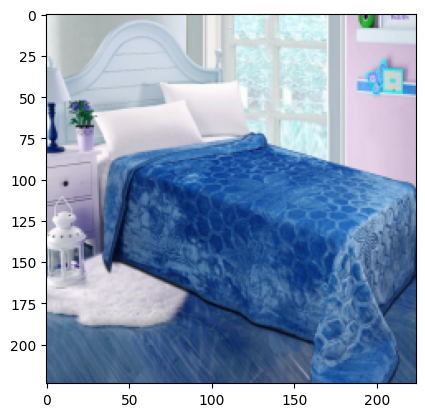

In [35]:
# plt.imshow(images_list[950])
# plt.imshow(images_list[954])
# plt.imshow(images_list[942])
# plt.imshow(images_list[105])
plt.imshow(images_list[941])

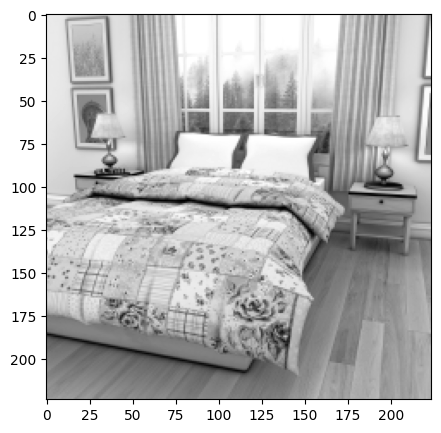

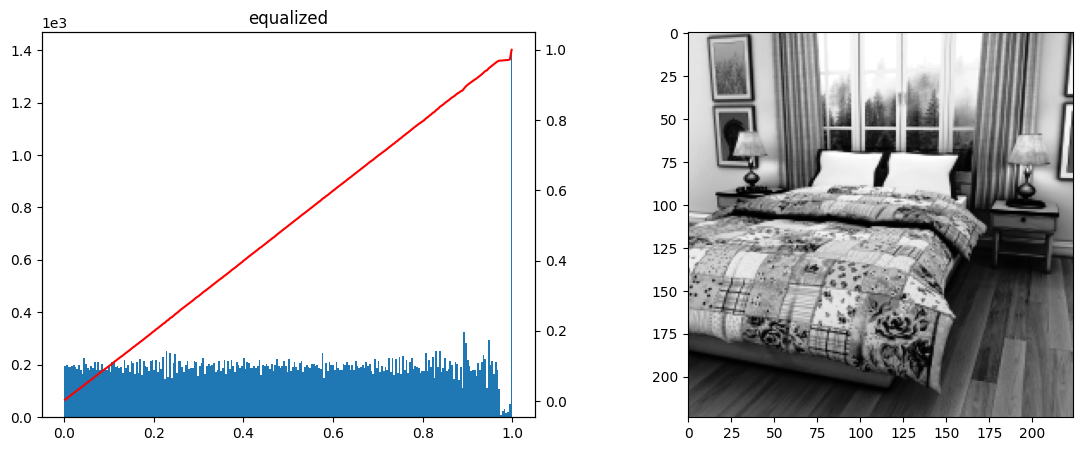

C:\Users\fuetu\AppData\Local\Temp\ipykernel_7652\2437911906.py:7: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  plot_img_hist(rank.equalize(img, footprint=footprint),'local equalized')


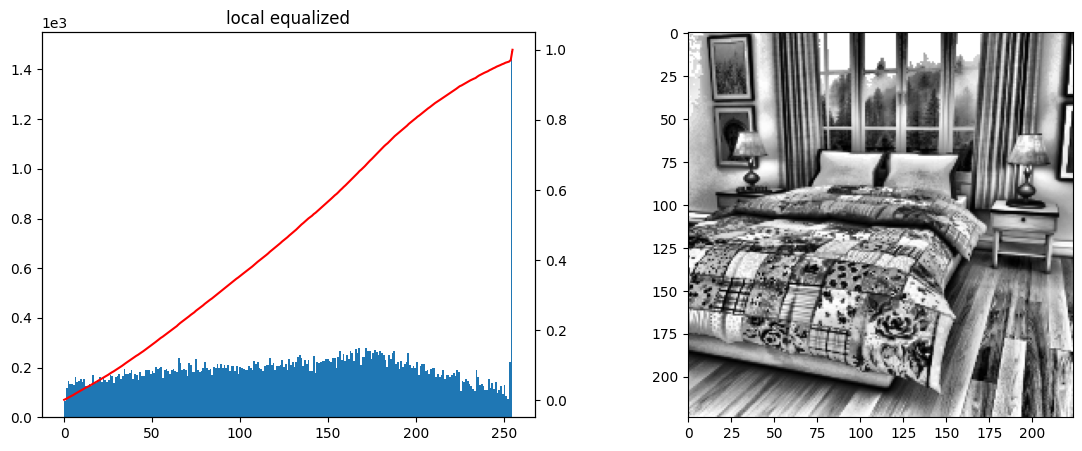

In [36]:
img = rgb2gray(images_list[950])
plt.figure(figsize=(5,5))
plt.imshow(img,cmap='gray')

plot_img_hist(exposure.equalize_hist(img),'equalized')
footprint = disk(20)
plot_img_hist(rank.equalize(img, footprint=footprint),'local equalized')

In [37]:
# from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
#                                  denoise_wavelet, estimate_sigma)


# sigma_est = estimate_sigma(img, average_sigmas=True)
# # Due to clipping in random_noise, the estimate will be a bit smaller than the
# # specified sigma.
# print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

# fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 5),
#                        sharex=True, sharey=True)



Estimated Gaussian noise standard deviation = 0.13725044381752585


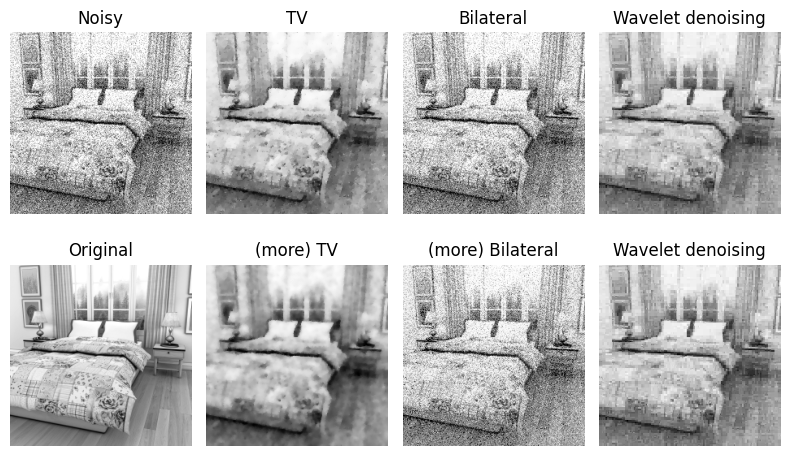

In [38]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.util import random_noise


sigma = 0.15
noisy = random_noise(img, var=sigma**2)
# noisy = img
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy')
ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.1))
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
ax[0, 2].imshow(denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15))
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')
ax[0, 3].imshow(denoise_wavelet(noisy,rescale_sigma=True))
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising')

ax[1, 1].imshow(denoise_tv_chambolle(noisy, weight=0.2))
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')
ax[1, 2].imshow(denoise_bilateral(noisy, sigma_color=0.1, sigma_spatial=15))
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')
ax[1, 3].imshow(denoise_wavelet(noisy,
                                rescale_sigma=True))
ax[1, 3].axis('off')
ax[1, 3].set_title('Wavelet denoising')
ax[1, 0].imshow(img)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()

### enhance edges => difference of gaussians

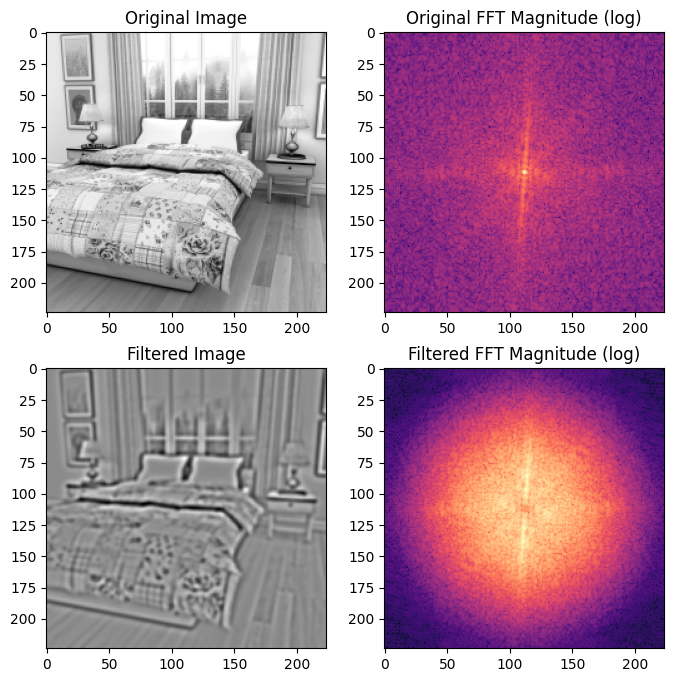

In [39]:
from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift
image = img
wimage = image * window('hann', image.shape)  # window image to improve FFT
filtered_image = difference_of_gaussians(image, 1.5)
filtered_wimage = filtered_image * window('hann', image.shape)
im_f_mag = fftshift(np.abs(fftn(wimage)))
fim_f_mag = fftshift(np.abs(fftn(filtered_wimage)))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(np.log(im_f_mag), cmap='magma')
ax[0, 1].set_title('Original FFT Magnitude (log)')
ax[1, 0].imshow(filtered_image, cmap='gray')
ax[1, 0].set_title('Filtered Image')
ax[1, 1].imshow(np.log(fim_f_mag), cmap='magma')
ax[1, 1].set_title('Filtered FFT Magnitude (log)')
plt.show()

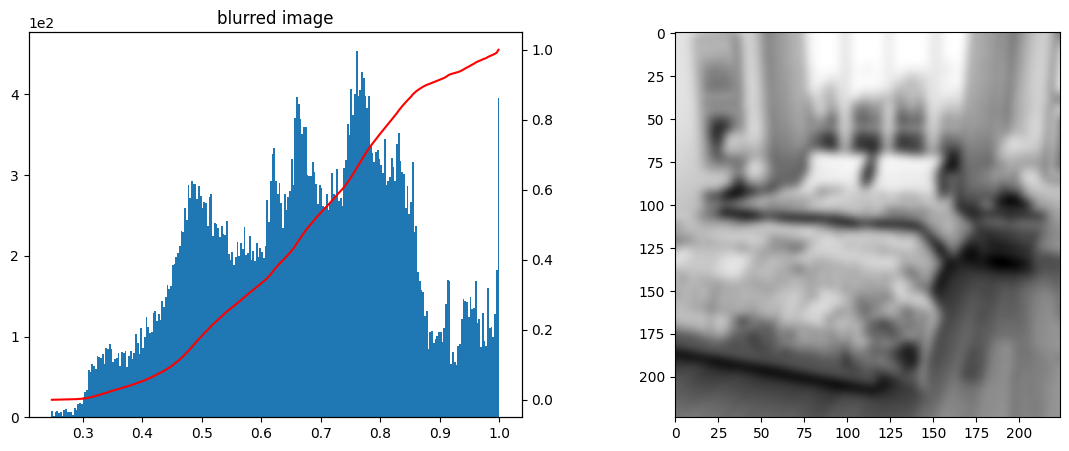

In [40]:
from skimage import filters
sigma = 3.0
blurred = filters.gaussian(image, sigma=(sigma, sigma), truncate=3.5)
plot_img_hist(blurred,'blurred image')

# Descriptors

In [145]:
from skimage import transform
from skimage.feature import match_descriptors, plot_matches, SIFT, ORB
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib
matplotlib.style.use('default')


### mise en place

In [42]:
img1 = img
img2 =  rgb2gray(images_list[941])

descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

(480, 128)


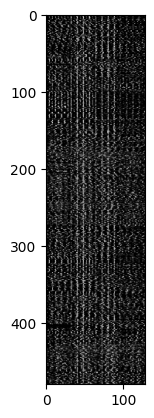

In [47]:
print(descriptors1.shape)
plt.imshow(descriptors1)

In [ ]:
# categ_0_list_num[0]
# np.ones(len(descriptor_list[0]))*categ_0_list_num[0]

In [140]:
descriptor_extractor = SIFT()
descriptor_list = []
descriptor_label0_list = []
categ_0_list_num, categ_0_names= pd.factorize(df['categ_0'])

sample_size = 100

for image, categ in zip(images_list[:sample_size],categ_0_list_num[:sample_size]):

    image = rgb2gray(image)  
    descriptor_extractor.detect_and_extract(image)
    desc_img = descriptor_extractor.descriptors
    descriptor_label0_list.extend(np.ones(len(desc_img)) * categ ) 
    descriptor_list.append(desc_img)

all_descriptor =np.vstack(descriptor_list)
all_descriptor_label = np.array(descriptor_label0_list)

In [128]:
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(all_descriptor)

KMeans(n_clusters=7, random_state=42)

In [129]:
tsne = TSNE(n_components =2)
out_tsne = tsne.fit_transform(all_descriptor)

c:\Users\fuetu\.virtualenvs\P23_remote_marketplace-UJLiqy4W\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\fuetu\.virtualenvs\P23_remote_marketplace-UJLiqy4W\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Clustering sur les descripteurs ')

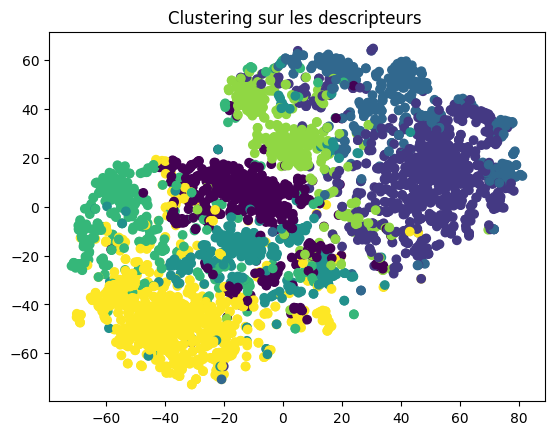

In [132]:
out_tsne.shape
plt.scatter(out_tsne[:,0], out_tsne[:,1], c=kmeans.labels_)
plt.title('Clustering sur les descripteurs ')

Text(0.5, 1.0, 'Clustering sur les descripteurs ')

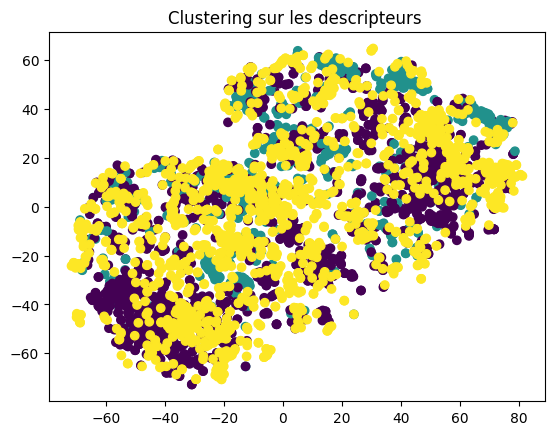

In [133]:
import matplotlib
matplotlib.style.use('default')
out_tsne.shape
plt.scatter(out_tsne[:,0], out_tsne[:,1], c=all_descriptor_label)
plt.title('Clustering sur les vrais labels')

In [ ]:
adjusted_rand_score(all_descriptor_label,kmeans.labels_)

### fonctions

In [157]:
def reduce_and_plot_compare(descriptors,descriptors_labels,reduce_first=False):
    if reduce_first:
        tsne = TSNE(n_components =2)
        descriptors = tsne.fit_transform(descriptors)
        title_reduce = 'après'

    kmeans = KMeans(n_clusters=7, random_state=42).fit(descriptors)
    
    if not reduce_first:
        tsne = TSNE(n_components =2)
        descriptors = tsne.fit_transform(descriptors)
        title_reduce = 'avant'

    ari_score = np.round(adjusted_rand_score(descriptors_labels,kmeans.labels_),3)

    plt.scatter(descriptors[:,0], descriptors[:,1], c=kmeans.labels_, s=2)
    plt.title(f'Clustering sur les descripteurs extraits {title_reduce} reduction de dim')
    plt.show()
    plt.scatter(descriptors[:,0], descriptors[:,1], c=descriptors_labels,s=2)
    plt.title(f'Vrais labels  ---  ARI score = {ari_score}')
    plt.show()

In [ ]:
categ_0_list_num

def get_descriptors_and_labels(image_list, label_list, sample_size = 100, extractor='SIFT'):
    descriptor_list = []
    descriptor_label0_list = []

    if extractor =='SIFT':
        descriptor_extractor = SIFT()
    if extractor =='ORB':
        descriptor_extractor = ORB(n_keypoints=200)

    for image, categ in zip(images_list[:sample_size], label_list[:sample_size]):
        image = rgb2gray(image)  
        descriptor_extractor.detect_and_extract(image)
        desc_img = descriptor_extractor.descriptors
        descriptor_label0_list.extend(np.ones(len(desc_img)) * categ ) 
        descriptor_list.append(desc_img)

        all_descriptor =np.vstack(descriptor_list)
        all_descriptor_label = np.array(descriptor_label0_list)

    return all_descriptor, all_descriptor_label



c:\Users\fuetu\.virtualenvs\P23_remote_marketplace-UJLiqy4W\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\fuetu\.virtualenvs\P23_remote_marketplace-UJLiqy4W\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


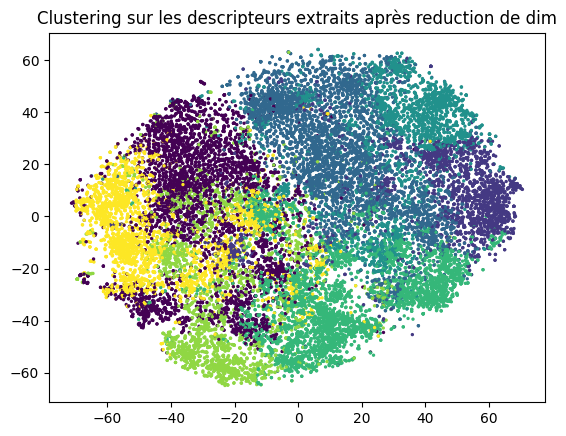

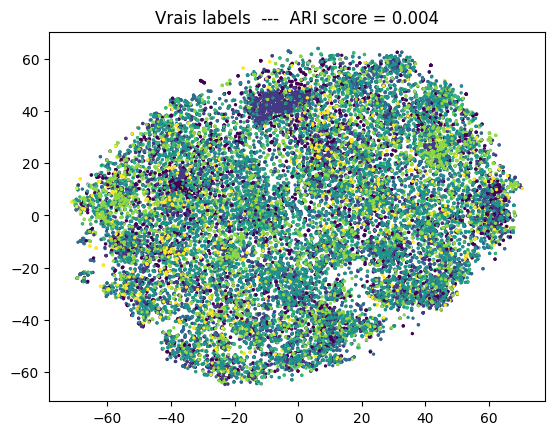

In [160]:
reduce_and_plot_compare(all_descriptor,all_descriptor_label)

c:\Users\fuetu\.virtualenvs\P23_remote_marketplace-UJLiqy4W\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\fuetu\.virtualenvs\P23_remote_marketplace-UJLiqy4W\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


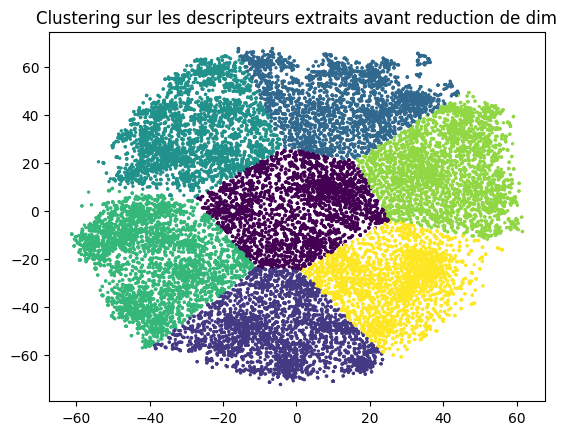

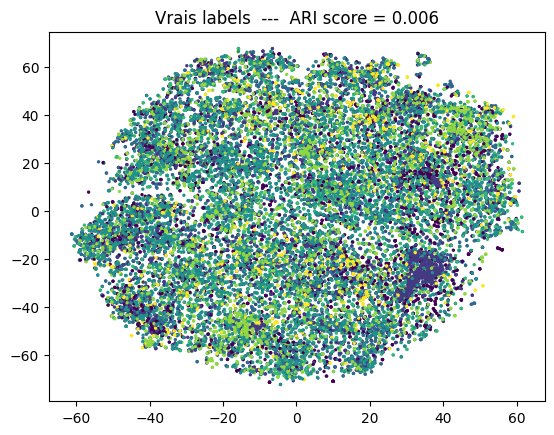

In [161]:
reduce_and_plot_compare(all_descriptor,all_descriptor_label,True)

c:\Users\fuetu\.virtualenvs\P23_remote_marketplace-UJLiqy4W\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\fuetu\.virtualenvs\P23_remote_marketplace-UJLiqy4W\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


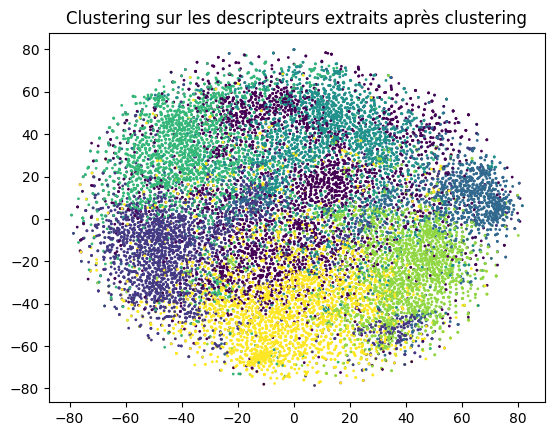

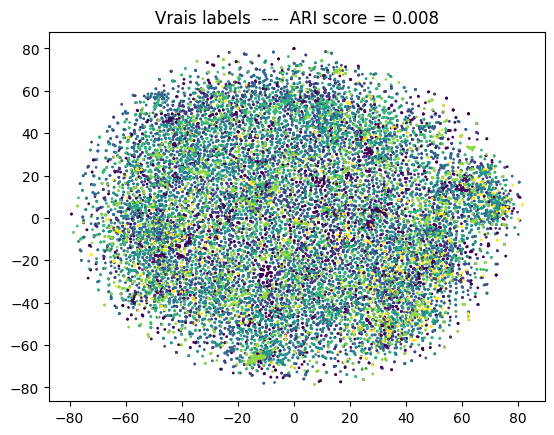

In [155]:
my_descriptor, my_descriptor_label = get_descriptors_and_labels(images_list, categ_0_list_num , sample_size = 100, extractor='ORB')
reduce_and_plot_compare(my_descriptor, my_descriptor_label, reduce_first=False)

In [48]:
# sift_cv = cv2.SIFT_create()
# # sift_cv.detectAndCompute(img, None)